# MRMS quality check with RQI

* Check the quality of re-gridded 0.1 deg MRMS and RQI
* Old notebook: file locations have been changed, cannot re-run

In [ ]:
import os
import sys
import time
import h5py
import pygrib
import numpy as np
import netCDF4 as nc
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## MRMS and RQI examples

In [5]:
# name_qc1 = '/glade/u/home/ksha/GAN_proj/MRMS_RadarAccumulationQualityIndex_01H_00.00_20210101-010000.grib2'
# name_qc2 = '/glade/u/home/ksha/GAN_proj/MRMS_RadarAccumulationQualityIndex_01H_00.00_20211125-210000.grib2'

# with pygrib.open(name_qc1) as grbio:
#     qc1_ = grbio[1].values

# with pygrib.open(name_qc2) as grbio:
#     qc2_ = grbio[1].values

In [10]:
def spatial_agregate(data, size=10):
    Nx, Ny = data.shape
    Nxa = Nx // 10; Nya = Ny // 10
    out = np.empty((Nxa, Nya))
    
    for i in range(Nxa):
        for j in range(Nya):
            out[i, j] = np.mean(data[i*size:(i*size+size), j*size:(j*size+size)])
    return out

In [13]:
with h5py.File(save_dir+'MRMS_RQI_example.hdf', 'r') as h5io:
    RQI = h5io['RQI'][...]

with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]

**Load and save MRMS 2021 data (moved to scripts)**

In [8]:
year = 2021
MRMS_dir = '/glade/campaign/cisl/aiml/ksha/MRMS_{}/'.format(year)

base = datetime(year, 1, 1)
date_list = [base + timedelta(hours=h) for h in range(365*24)]

dt = date_list[0]
dt_str = datetime.strftime(dt, '%Y%m%d-%H%M%S')

In [22]:
shape_grid = lon_01.shape
MRMS_save = np.empty((len(date_list),)+shape_grid); MRMS[...] = np.nan

In [23]:
for i_dt, dt in enumerate(date_list[:2]):

    filename = MRMS_dir+'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str)

    with pygrib.open(filename) as grbio:
        MRMS = grbio[1].values
    MRMS = np.flipud(MRMS)

    MRMS_save[i_dt, ...] = spatial_agregate(MRMS, size=10)[47:303, 53:629]

In [24]:
# tuple_save = (MRMS_save,)
# label_save = ['MRMS',]
# du.save_hdf5(tuple_save, label_save, '/glade/campaign/cisl/aiml/ksha/GFS/', 'MRMS_y{}.hdf'.format(year))

Save to /glade/campaign/cisl/aiml/ksha/GFS/MRMS_y2021.hdf


**Re-gridded MRMS and RQI examples**

In [17]:
MRMS01 = spatial_agregate(MRMS, size=10)[47:303, 53:629]
RQI01 = spatial_agregate(RQI, size=10)[47:303, 53:629]

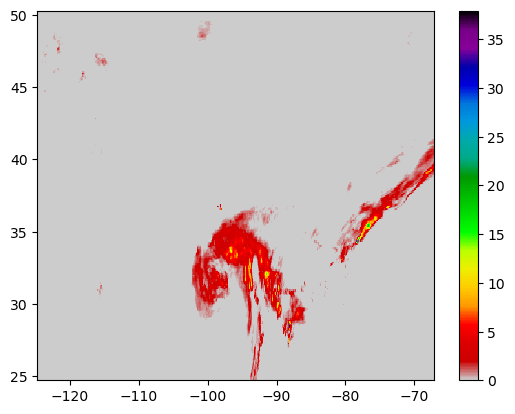

In [19]:
plt.pcolormesh(lon_01, lat_01, MRMS01, cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

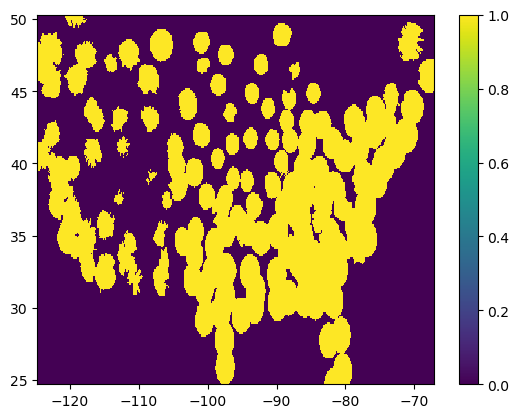

In [20]:
plt.pcolormesh(lon_01, lat_01, RQI01 > 0.75)
plt.colorbar()